# Train Mask-RCNN to detect and classify Composite Fillers (Fibers and Particles)

In [1]:
# Import all libraries
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
from pathlib import Path

In [2]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = '../Mask_RCNN/'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

Using TensorFlow backend.


In [3]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [5]:
class FillerSynthConfig(Config):
    """Configuration for training on the composite fillers synthetic dataset.
    Derives from the base Config class and overrides specific values.
    """
    # Give the configuration a recognizable name
    NAME = "Composite"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 2 fillers types

    # All of our training images are 256x256
    IMAGE_MIN_DIM = 256 
    IMAGE_MAX_DIM = 256

    # can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 1000

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500
    POST_NMS_ROIS_TRAINING = 100
    
config = FillerSynthConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [6]:
class CompositeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [7]:
dataset_train = CompositeDataset()
dataset_train.load_data('dataset/train/mycoco_instances.json',
                        'dataset/train/images')
dataset_train.prepare()

dataset_val = CompositeDataset()
dataset_val.load_data('dataset/val/mycoco_instances.json',
                        'dataset/val/images')
dataset_val.prepare()

Displaying examples from training dataset:


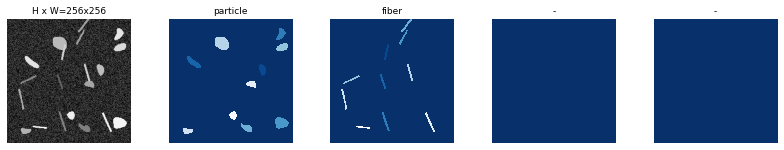

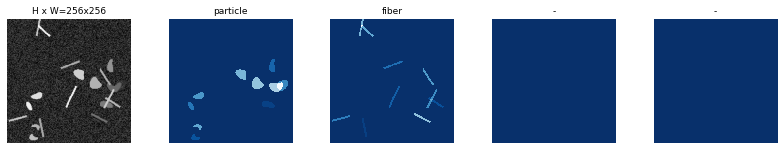

Displaying examples from validation dataset:


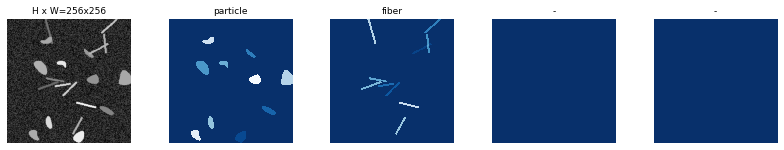

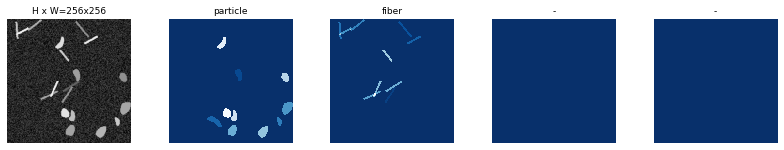

In [8]:
for name, dataset in [('training', dataset_train), ('validation', dataset_val)]:
    print(f'Displaying examples from {name} dataset:')
    
    image_ids = np.random.choice(dataset.image_ids, 2)
    for image_id in image_ids:
        image = dataset.load_image(image_id)
        mask, class_ids = dataset.load_mask(image_id)
        visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [11]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [12]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=4, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: ../Mask_RCNN/logs\composite20190919T2018\mask_rcnn_composite_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn

C:\Users\Fashiar\Anaconda3\envs\mycoco\lib\site-packages\tensorflow\python\ops\gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/4
1000/1000 [==============================] - 138s 138ms/step - loss: 1.3643 - rpn_class_loss: 0.0644 - rpn_bbox_loss: 0.5510 - mrcnn_class_loss: 0.3157 - mrcnn_bbox_loss: 0.2236 - mrcnn_mask_loss: 0.2096 - val_loss: 1.0535 - val_rpn_class_loss: 0.0441 - val_rpn_bbox_loss: 0.4250 - val_mrcnn_class_loss: 0.2881 - val_mrcnn_bbox_loss: 0.1391 - val_mrcnn_mask_loss: 0.1573
Epoch 2/4
 974/1000 [============================>.] - ETA: 3s - loss: 0.9495 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.3276 - mrcnn_class_loss: 0.2686 - mrcnn_bbox_loss: 0.1481 - mrcnn_mask_loss: 0.1707

ERROR:root:Error processing image {'id': 138, 'source': 'coco_like', 'path': 'C:\\Users\\Fashiar\\Research\\DL\\CocoSynth\\Github_upload\\dataset\\train\\images\\00138.png', 'width': 256, 'height': 256, 'annotations': [{'segmentation': [[1, 67, 2, 67, 0, 68, 1, 68, 2, 68, 3, 68, 4, 68, 0, 69, 1, 69, 2, 69, 3, 69, 4, 69, 5, 69, 1, 70, 2, 70, 3, 70, 4, 70, 5, 70, 6, 70, 2, 71, 3, 71, 4, 71, 5, 71, 6, 71, 7, 71, 8, 71, 3, 72, 4, 72, 5, 72, 6, 72, 7, 72, 8, 72, 9, 72, 5, 73, 6, 73, 7, 73, 8, 73, 9, 73, 10, 73, 6, 74, 7, 74, 8, 74, 9, 74, 10, 74, 11, 74, 7, 75, 8, 75, 9, 75, 10, 75, 11, 75, 12, 75, 13, 75, 8, 76, 9, 76, 10, 76, 11, 76, 12, 76, 13, 76, 14, 76, 10, 77, 11, 77, 12, 77, 13, 77, 14, 77, 15, 77, 11, 78, 12, 78, 13, 78, 14, 78, 15, 78, 16, 78, 12, 79, 13, 79, 14, 79, 15, 79, 16, 79, 17, 79, 18, 79, 14, 80, 15, 80, 16, 80, 17, 80, 18, 80, 19, 80, 15, 81, 16, 81, 17, 81, 18, 81, 19, 81, 20, 81, 16, 82, 17, 82, 18, 82, 19, 82, 20, 82, 21, 82, 22, 82, 17, 83, 18, 83, 19, 83, 20, 83, 2

1000/1000 [==============================] - 132s 132ms/step - loss: 0.9487 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.3271 - mrcnn_class_loss: 0.2690 - mrcnn_bbox_loss: 0.1481 - mrcnn_mask_loss: 0.1701 - val_loss: 0.8530 - val_rpn_class_loss: 0.0340 - val_rpn_bbox_loss: 0.3400 - val_mrcnn_class_loss: 0.2126 - val_mrcnn_bbox_loss: 0.1293 - val_mrcnn_mask_loss: 0.1373
Epoch 3/4
1000/1000 [==============================] - 146s 146ms/step - loss: 0.8313 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 0.2747 - mrcnn_class_loss: 0.2422 - mrcnn_bbox_loss: 0.1294 - mrcnn_mask_loss: 0.1561 - val_loss: 1.0306 - val_rpn_class_loss: 0.0599 - val_rpn_bbox_loss: 0.3336 - val_mrcnn_class_loss: 0.2290 - val_mrcnn_bbox_loss: 0.1855 - val_mrcnn_mask_loss: 0.2225
Epoch 4/4
 403/1000 [===========>..................] - ETA: 1:28 - loss: 0.8070 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 0.2554 - mrcnn_class_loss: 0.2436 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.1550

ERROR:root:Error processing image {'id': 138, 'source': 'coco_like', 'path': 'C:\\Users\\Fashiar\\Research\\DL\\CocoSynth\\Github_upload\\dataset\\train\\images\\00138.png', 'width': 256, 'height': 256, 'annotations': [{'segmentation': [[1, 67, 2, 67, 0, 68, 1, 68, 2, 68, 3, 68, 4, 68, 0, 69, 1, 69, 2, 69, 3, 69, 4, 69, 5, 69, 1, 70, 2, 70, 3, 70, 4, 70, 5, 70, 6, 70, 2, 71, 3, 71, 4, 71, 5, 71, 6, 71, 7, 71, 8, 71, 3, 72, 4, 72, 5, 72, 6, 72, 7, 72, 8, 72, 9, 72, 5, 73, 6, 73, 7, 73, 8, 73, 9, 73, 10, 73, 6, 74, 7, 74, 8, 74, 9, 74, 10, 74, 11, 74, 7, 75, 8, 75, 9, 75, 10, 75, 11, 75, 12, 75, 13, 75, 8, 76, 9, 76, 10, 76, 11, 76, 12, 76, 13, 76, 14, 76, 10, 77, 11, 77, 12, 77, 13, 77, 14, 77, 15, 77, 11, 78, 12, 78, 13, 78, 14, 78, 15, 78, 16, 78, 12, 79, 13, 79, 14, 79, 15, 79, 16, 79, 17, 79, 18, 79, 14, 80, 15, 80, 16, 80, 17, 80, 18, 80, 19, 80, 15, 81, 16, 81, 17, 81, 18, 81, 19, 81, 20, 81, 16, 82, 17, 82, 18, 82, 19, 82, 20, 82, 21, 82, 22, 82, 17, 83, 18, 83, 19, 83, 20, 83, 2

1000/1000 [==============================] - 147s 147ms/step - loss: 0.7945 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.2494 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.1507 - val_loss: 0.7666 - val_rpn_class_loss: 0.0360 - val_rpn_bbox_loss: 0.2836 - val_mrcnn_class_loss: 0.2059 - val_mrcnn_bbox_loss: 0.0887 - val_mrcnn_mask_loss: 0.1523
Training took 9.83 minutes


In [13]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=8, 
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 4. LR=0.0001

Checkpoint Path: ../Mask_RCNN/logs\composite20190919T2018\mask_rcnn_composite_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2

C:\Users\Fashiar\Anaconda3\envs\mycoco\lib\site-packages\tensorflow\python\ops\gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 5/8
1000/1000 [==============================] - 205s 205ms/step - loss: 0.6849 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.2187 - mrcnn_class_loss: 0.2085 - mrcnn_bbox_loss: 0.0973 - mrcnn_mask_loss: 0.1368 - val_loss: 0.7569 - val_rpn_class_loss: 0.0278 - val_rpn_bbox_loss: 0.2455 - val_mrcnn_class_loss: 0.2372 - val_mrcnn_bbox_loss: 0.0939 - val_mrcnn_mask_loss: 0.1526
Epoch 6/8
 563/1000 [===============>..............] - ETA: 1:24 - loss: 0.6692 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.2103 - mrcnn_class_loss: 0.2061 - mrcnn_bbox_loss: 0.0969 - mrcnn_mask_loss: 0.1333

ERROR:root:Error processing image {'id': 138, 'source': 'coco_like', 'path': 'C:\\Users\\Fashiar\\Research\\DL\\CocoSynth\\Github_upload\\dataset\\train\\images\\00138.png', 'width': 256, 'height': 256, 'annotations': [{'segmentation': [[1, 67, 2, 67, 0, 68, 1, 68, 2, 68, 3, 68, 4, 68, 0, 69, 1, 69, 2, 69, 3, 69, 4, 69, 5, 69, 1, 70, 2, 70, 3, 70, 4, 70, 5, 70, 6, 70, 2, 71, 3, 71, 4, 71, 5, 71, 6, 71, 7, 71, 8, 71, 3, 72, 4, 72, 5, 72, 6, 72, 7, 72, 8, 72, 9, 72, 5, 73, 6, 73, 7, 73, 8, 73, 9, 73, 10, 73, 6, 74, 7, 74, 8, 74, 9, 74, 10, 74, 11, 74, 7, 75, 8, 75, 9, 75, 10, 75, 11, 75, 12, 75, 13, 75, 8, 76, 9, 76, 10, 76, 11, 76, 12, 76, 13, 76, 14, 76, 10, 77, 11, 77, 12, 77, 13, 77, 14, 77, 15, 77, 11, 78, 12, 78, 13, 78, 14, 78, 15, 78, 16, 78, 12, 79, 13, 79, 14, 79, 15, 79, 16, 79, 17, 79, 18, 79, 14, 80, 15, 80, 16, 80, 17, 80, 18, 80, 19, 80, 15, 81, 16, 81, 17, 81, 18, 81, 19, 81, 20, 81, 16, 82, 17, 82, 18, 82, 19, 82, 20, 82, 21, 82, 22, 82, 17, 83, 18, 83, 19, 83, 20, 83, 2

1000/1000 [==============================] - 194s 194ms/step - loss: 0.6653 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.2089 - mrcnn_class_loss: 0.2037 - mrcnn_bbox_loss: 0.0971 - mrcnn_mask_loss: 0.1330 - val_loss: 0.6605 - val_rpn_class_loss: 0.0163 - val_rpn_bbox_loss: 0.2406 - val_mrcnn_class_loss: 0.1524 - val_mrcnn_bbox_loss: 0.1192 - val_mrcnn_mask_loss: 0.1321
Epoch 7/8
 738/1000 [=====================>........] - ETA: 49s - loss: 0.6443 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.2036 - mrcnn_class_loss: 0.1999 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.1287 - ETA:  - ETA: 1:41 - loss: 0.6415 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.2014 - mrcnn_class_loss: 0.2006 - mrcnn_bbox_loss: 0.0892 - mrcnn_

ERROR:root:Error processing image {'id': 138, 'source': 'coco_like', 'path': 'C:\\Users\\Fashiar\\Research\\DL\\CocoSynth\\Github_upload\\dataset\\train\\images\\00138.png', 'width': 256, 'height': 256, 'annotations': [{'segmentation': [[1, 67, 2, 67, 0, 68, 1, 68, 2, 68, 3, 68, 4, 68, 0, 69, 1, 69, 2, 69, 3, 69, 4, 69, 5, 69, 1, 70, 2, 70, 3, 70, 4, 70, 5, 70, 6, 70, 2, 71, 3, 71, 4, 71, 5, 71, 6, 71, 7, 71, 8, 71, 3, 72, 4, 72, 5, 72, 6, 72, 7, 72, 8, 72, 9, 72, 5, 73, 6, 73, 7, 73, 8, 73, 9, 73, 10, 73, 6, 74, 7, 74, 8, 74, 9, 74, 10, 74, 11, 74, 7, 75, 8, 75, 9, 75, 10, 75, 11, 75, 12, 75, 13, 75, 8, 76, 9, 76, 10, 76, 11, 76, 12, 76, 13, 76, 14, 76, 10, 77, 11, 77, 12, 77, 13, 77, 14, 77, 15, 77, 11, 78, 12, 78, 13, 78, 14, 78, 15, 78, 16, 78, 12, 79, 13, 79, 14, 79, 15, 79, 16, 79, 17, 79, 18, 79, 14, 80, 15, 80, 16, 80, 17, 80, 18, 80, 19, 80, 15, 81, 16, 81, 17, 81, 18, 81, 19, 81, 20, 81, 16, 82, 17, 82, 18, 82, 19, 82, 20, 82, 21, 82, 22, 82, 17, 83, 18, 83, 19, 83, 20, 83, 2

1000/1000 [==============================] - 190s 190ms/step - loss: 0.6459 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.2027 - mrcnn_class_loss: 0.1992 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1309 - val_loss: 0.6609 - val_rpn_class_loss: 0.0362 - val_rpn_bbox_loss: 0.2049 - val_mrcnn_class_loss: 0.2514 - val_mrcnn_bbox_loss: 0.0595 - val_mrcnn_mask_loss: 0.1089
Epoch 8/8
1000/1000 [==============================] - 190s 190ms/step - loss: 0.6415 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1958 - mrcnn_class_loss: 0.1988 - mrcnn_bbox_loss: 0.0953 - mrcnn_mask_loss: 0.1307 - val_loss: 0.5853 - val_rpn_class_loss: 0.0110 - val_rpn_bbox_loss: 0.1859 - val_mrcnn_class_loss: 0.1867 - val_mrcnn_bbox_loss: 0.0757 - val_mrcnn_mask_loss: 0.1261
Training took 13.23 minutes


In [14]:
class InferenceConfig(FillerSynthConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    DETECTION_MIN_CONFIDENCE = 0.70
    

inference_config = InferenceConfig()

In [15]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [16]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = str(Path(ROOT_DIR) / "logs" / "composite20190919T2018/mask_rcnn_composite_0008.h5" )
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ../Mask_RCNN/logs\composite20190919T2018\mask_rcnn_composite_0008.h5
Re-starting from epoch 8


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  245.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  141.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


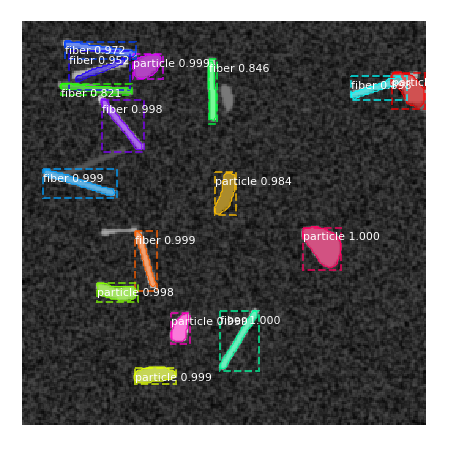

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  242.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  138.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


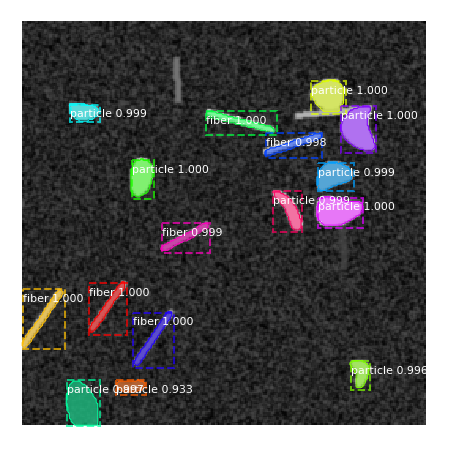

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  242.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  138.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


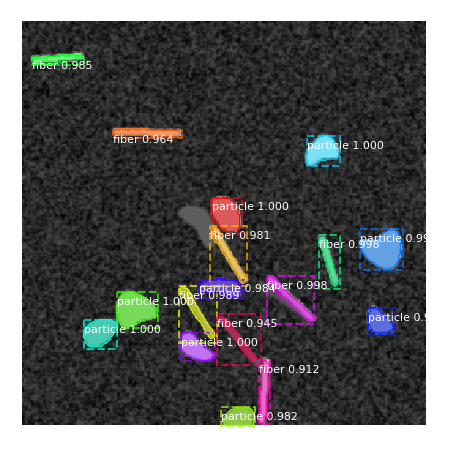

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  242.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  138.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


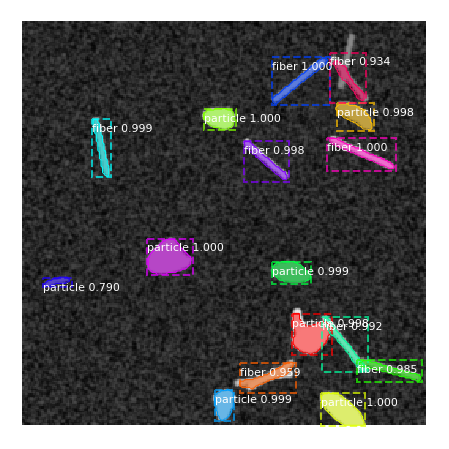

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  243.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  139.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


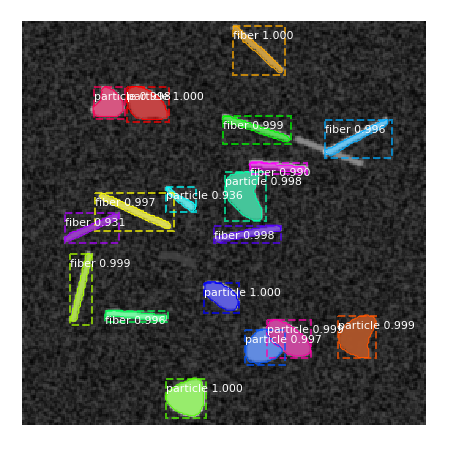

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  242.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  138.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


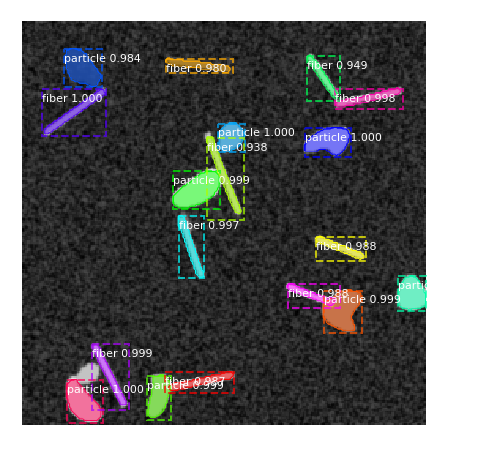

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  243.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  139.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


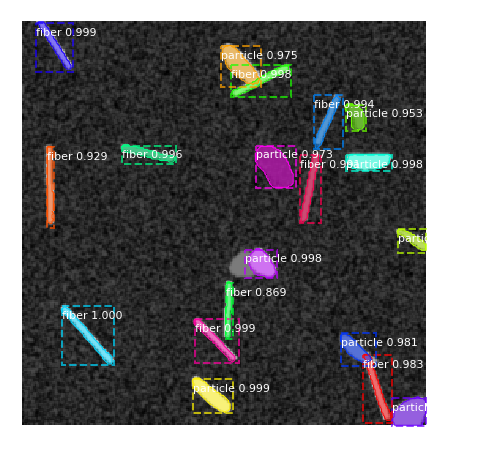

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  244.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  140.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


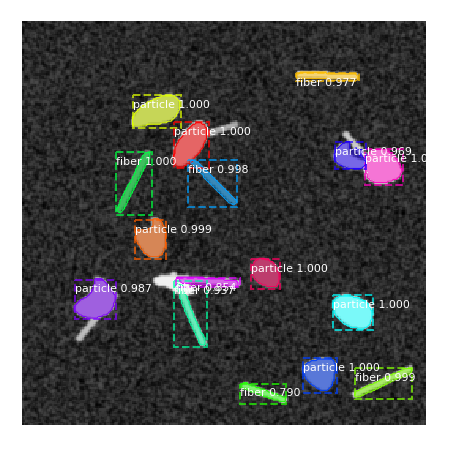

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  243.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  139.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


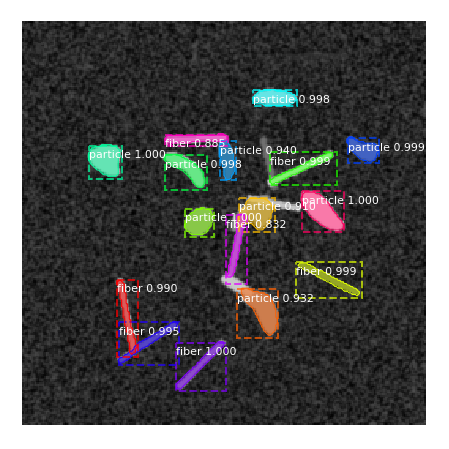

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  241.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  137.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


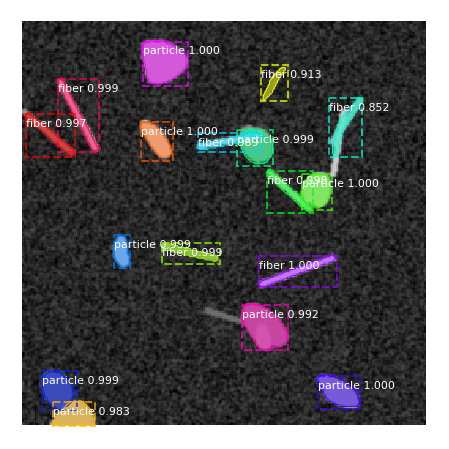

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  242.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  138.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


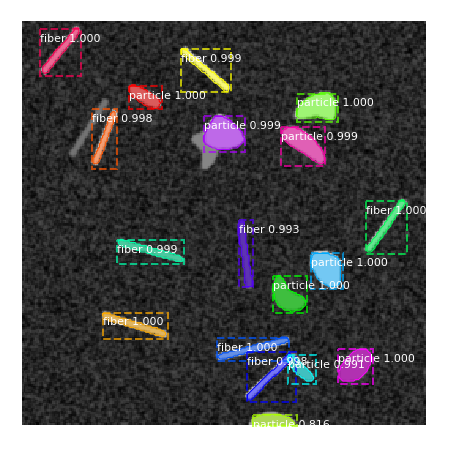

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  243.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  139.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


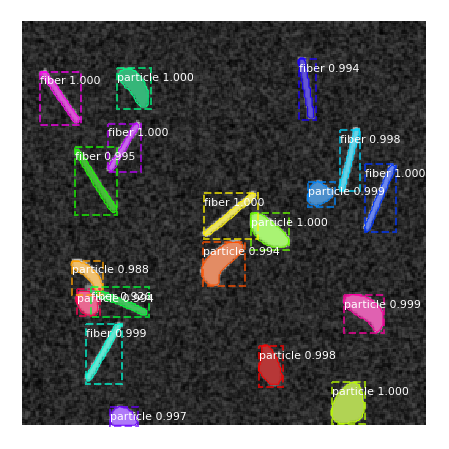

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  245.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  141.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


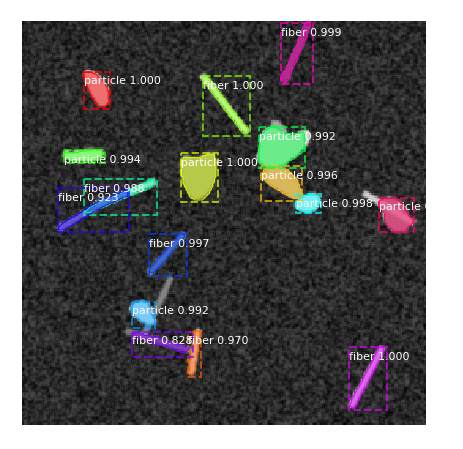

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  246.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  142.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


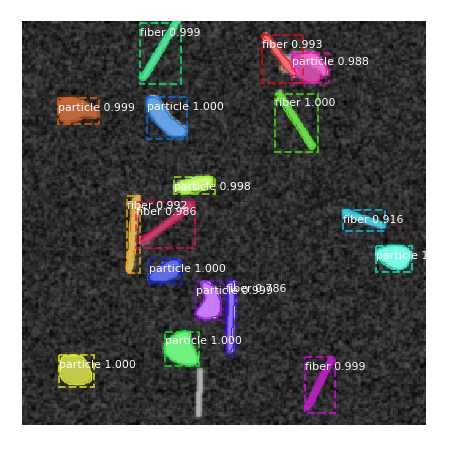

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  243.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  139.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


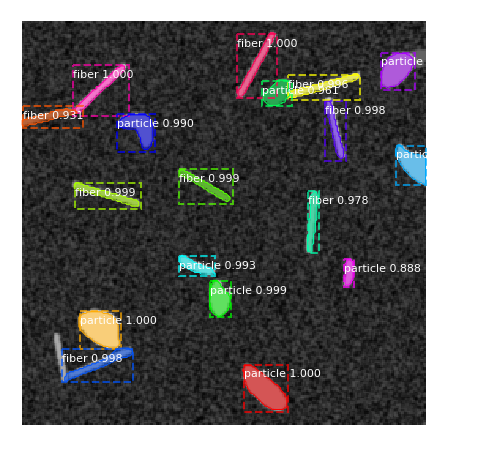

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  244.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  140.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


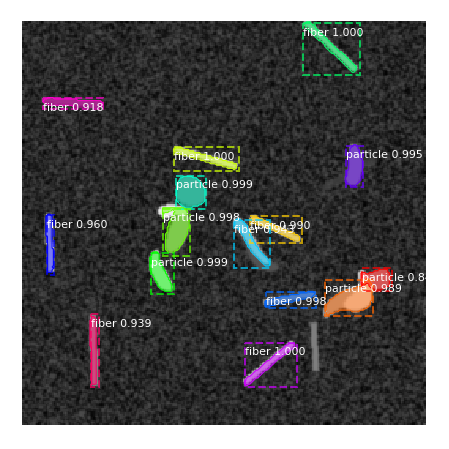

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  246.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  142.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


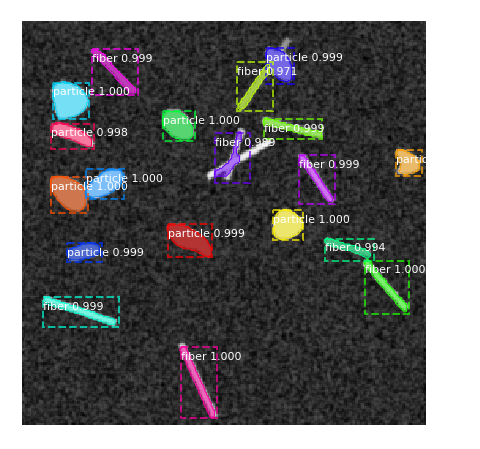

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  244.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  140.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


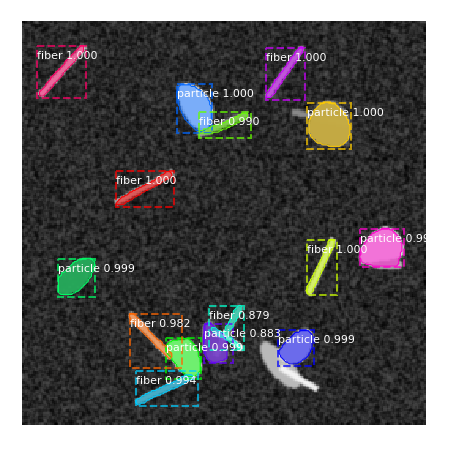

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  242.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  138.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


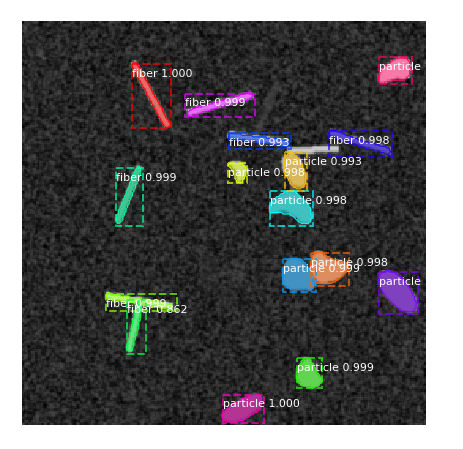

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  246.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  142.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


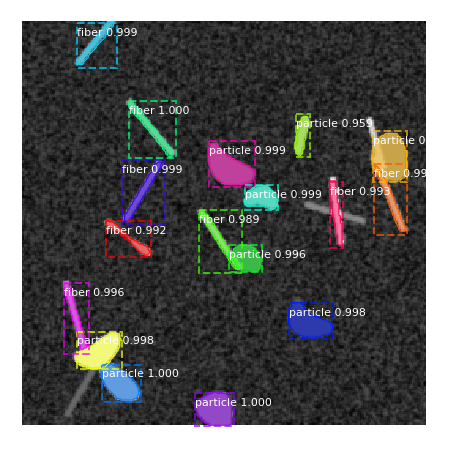

In [17]:
import cv2

real_test_dir = 'dataset/test/images'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = cv2.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_train.class_names, r['scores'], figsize=(8,8))